# Shift Adressing expriment

In this simple experiment we ask network to use NTM style adressing to retrieve a contiguous subsequence of elements from memory.

The experiment goes as follows. We create a random memory matrix and we extract a random row. This row is then fed as input to the Read head. We then query the network **shift_per_example** many times and we expect to get out the row that was fed at input, then the next row in memory, then the row two positions away an so on. Since we have no controller to we feed an extra bit of information to the network - the bit is 0 if we are at first timestep T=0 and 1 otherwise. 

The "controller bit" is cruitial and since it tends to be burried in the noise, we multiply it's learnining rate by memory_size.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import unittest
import numpy as np
import dali.core as D
import matplotlib.pyplot as plt

from dali.utils import Solver, RunningAverage, Capture

from memory_access import NTMReadHead
from utils import list_vector_to_mat

In [149]:
memory_size = 20
memory_locations = 128
shifts_per_example = 7

model = NTMReadHead(input_sizes=[memory_size, 1],
                    memory_locations=memory_locations,
                    memory_size=memory_size)
model.name_parameters("model")
initial_locations = D.Mat.zeros((1, memory_locations), constant=True)
solver = Solver(model.parameters(), "rmsprop", learning_rate=0.003)

# oddly this part is crutial
for param in model.parameters():
    if 'matrices[1]' in param.name:
        solver.set_lr_multiplier(param.name, float(memory_size))
        print("Learning rate for %s multiplied by %d" % (param.name, memory_size))

def generate_example(timesteps):
    memory = D.random.uniform(-1.0, 1.0,
        size=(memory_locations, memory_size))
    memory.constant = True

    start_location = random.randint(0, memory_locations - 1)
    
    rows = []
    with D.NoBackprop():
        for i in range(start_location, start_location + timesteps):
            rows.append(memory[i % memory_locations])
            rows[-1].constant = True

    inputs = [[rows[0], D.Mat.zeros((1,1), constant=True)]] + \
             [[D.Mat.zeros((1, memory_size)), D.Mat.ones((1,1), constant=True)] for _ in range(len(rows) - 1)]
            
    return memory, inputs, rows, start_location

EPOCHS = 10000
MINIBATCH = 3

error_estimate = RunningAverage(0.99)
lowest_error = float('inf')
best_params = None


try:
    for epoch in range(EPOCHS):
        for _ in range(MINIBATCH):
            memory, inputs, rows, row_idx = generate_example(shifts_per_example)


            head_state = model.initial_states()
            error = D.Mat.zeros((1,1), constant=True)
            for inpt, target in zip(inputs, rows):
                retrieved, head_state    = model.read(inpt, memory, head_state)
                error = error +  ((target - retrieved) ** 2).sum()
            (error / MINIBATCH).grad()
            D.Graph.backward()
            error_estimate.update(error.w[0,0])
        if lowest_error > float(error_estimate):
            lowest_error = float(error_estimate)
            best_params = [p.get_value(copy=True) for p in model.parameters()]
        if epoch % 100 == 0:
            print("Epoch ", epoch, " error = ", float(error_estimate), flush=True)
        solver.step()
except KeyboardInterrupt:
    pass

for param, best_param in zip(model.parameters(), best_params):
    param.w = best_param

Learning rate for model_adressing_content_key.matrices[1] multiplied by 20
Learning rate for model_adressing_content_key_strength.matrices[1] multiplied by 20
Learning rate for model_adressing_interpolation.matrices[1] multiplied by 20
Learning rate for model_adressing_shift.matrices[1] multiplied by 20
Learning rate for model_adressing_focus.matrices[1] multiplied by 20
Epoch  0  error =  44.497150315475466
Epoch  100  error =  45.690615659792684
Epoch  200  error =  42.81805854159544
Epoch  300  error =  36.41513802047649
Epoch  400  error =  29.61520411750467
Epoch  500  error =  26.336048541032817
Epoch  600  error =  25.052394342518205
Epoch  700  error =  22.086407495887595
Epoch  800  error =  21.021242635341252
Epoch  900  error =  19.563115585221645
Epoch  1000  error =  18.054774291206556
Epoch  1100  error =  11.654980656760719
Epoch  1200  error =  9.304408566590325
Epoch  1300  error =  4.7911665029536055
Epoch  1400  error =  3.3604395397623965
Epoch  1500  error =  0.316

In [151]:
def accuracy(timesteps):
    EVAL_EXAMPLES = 100
    num_correct = 0
    num_total   = 0
    with D.NoBackprop():
        for _ in range(EVAL_EXAMPLES):
            memory, inputs, rows, first_row_idx = generate_example(timesteps)

            head_state = model.initial_states()
            for inpt, target in zip(inputs, rows):
                retrieved, head_state    = model.read(inpt, memory, head_state)

                num_correct += sum(abs(target - retrieved).w[0] < 0.1)
                num_total += retrieved.shape[0] * retrieved.shape[1]
    return num_correct / num_total

print("Accuracy for %d timesteps is %.0f %%" % (shifts_per_example // 2, 100.0 * accuracy(shifts_per_example // 2)))
print("Accuracy for %d timesteps is %.0f %%" % (shifts_per_example, 100.0 * accuracy(shifts_per_example)))
print("Accuracy for %d timesteps is %.0f %%" % (shifts_per_example * 2, 100.0 * accuracy(shifts_per_example * 2)))

Accuracy for 3 timesteps is 97 %
Accuracy for 7 timesteps is 99 %
Accuracy for 14 timesteps is 98 %


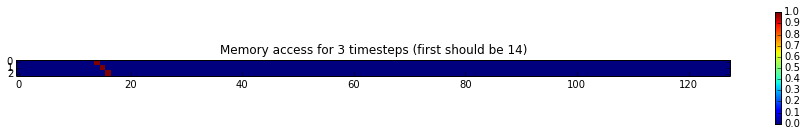

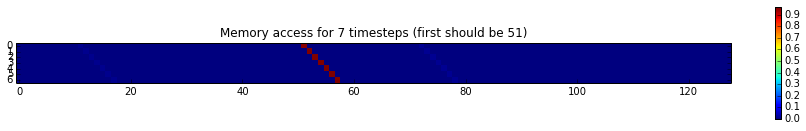

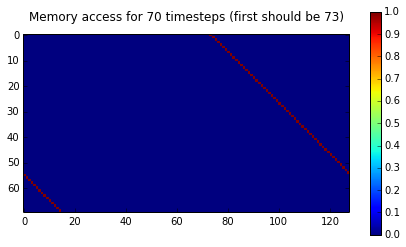

In [153]:
def visualize_memory(timesteps):
    c = Capture()
    with D.NoBackprop():
        with c:
            memory, inputs, rows, first_row_idx = generate_example(timesteps)

            head_state = model.initial_states()
            for inpt, target in zip(inputs, rows):
                retrieved, head_state    = model.read(inpt, memory, head_state)
    ax = plt.matshow(list_vector_to_mat(c.state["read_head_weights"]))
    plt.title("Memory access for %d timesteps (first should be %d)" % (timesteps, first_row_idx) )
    plt.colorbar()
    ax.axes.xaxis.set_ticks_position('bottom')
visualize_memory(shifts_per_example // 2)
visualize_memory(shifts_per_example)
visualize_memory(shifts_per_example * 10)

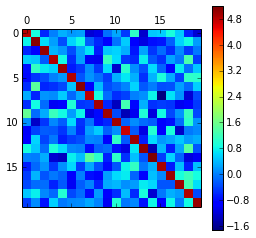

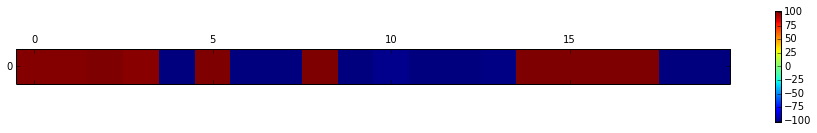

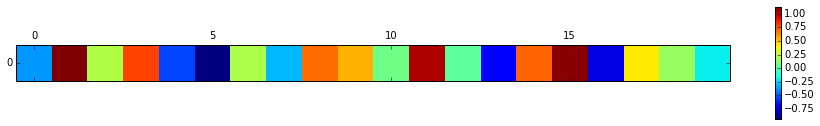

In [154]:
def show_module(m):
    plt.matshow(m.matrices[0])
    plt.colorbar()
    plt.matshow(m.matrices[1])
    plt.colorbar()
    plt.matshow(m.b)
    plt.colorbar()

def print_module(m):
    print(m.matrices[0].w)
    print(m.b.w)
    
show_module(model.addressing.content_key)

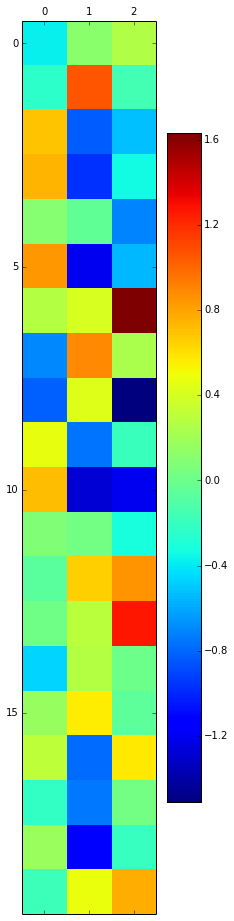

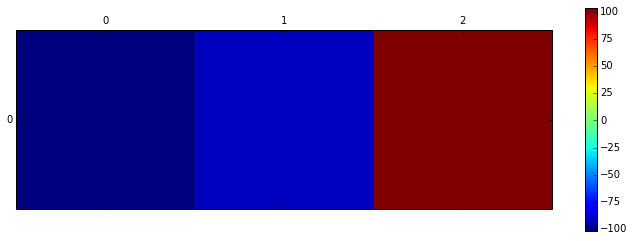

In [ ]:
show_module(model.addressing.shift)

In [117]:
print_module(model.addressing.interpolation)

[[ 4.7683177 ]
 [ 1.5772413 ]
 [ 6.19783115]
 [-0.93345594]
 [ 1.32073438]]
[[ 16.26532936]]


In [118]:
print_module(model.addressing.focus)

[[-4.34807014]
 [-2.79266238]
 [ 0.53355837]
 [ 0.25169346]
 [ 6.61313248]]
[[ 7.10945797]]
